In [1]:
import os
from datetime import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import csv
from csv import writer



#tensorflow import
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.activations import relu,linear
from tensorflow.keras.optimizers import Adam

#logging
from tensorflow import keras
from keras import backend as K


#custom functions import
from ts_functions import time_window_generator
from aux_functions import aux_functions


mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
#option flags
debug_mode = True
debug_output_n = 2

performance_log = True
data_log_csv_path = "training_log/newframe_sm_ma_hs300_30win.csv"


#tensorboard logging doesnt work for now
tf_log_dir = "logs/LSTM_stocks/"




In [3]:
fileDir = os.path.dirname(os.path.realpath('__file__'))
filename = os.path.join(fileDir, r"stock_data\index300_05_22_day.csv")

In [4]:
drop_list = ['change']

df = pd.read_csv(filename).drop(drop_list, axis=1)

In [5]:
if debug_mode:
    display(df)

,ts_code,trade_date,open,high,low,close,pre_close,pct_chg,vol,amount
0,600783.SH,20221215,13.63,13.63,13.38,13.58,13.55,0.2214,38397.67,51819.5570
1,600783.SH,20221214,13.54,13.82,13.42,13.55,13.46,0.6686,57557.68,78307.7080
2,600783.SH,20221213,13.12,13.65,13.10,13.46,13.24,1.6616,74087.26,99829.4500
3,600783.SH,20221212,13.25,13.46,13.04,13.24,13.29,-0.3762,60428.45,79917.9930
4,600783.SH,20221209,13.56,13.60,13.19,13.29,13.53,-1.7738,66449.00,88408.6250
...,...,...,...,...,...,...,...,...,...,...
1743021,002064.SZ,20060829,9.60,9.79,9.50,9.65,9.63,0.2100,58861.23,56827.0509
1743022,002064.SZ,20060828,9.61,9.91,9.42,9.63,9.54,0.9400,75694.74,73239.1825
1743023,002064.SZ,20060825,9.22,10.00,9.13,9.54,9.28,2.8000,121564.97,115534.6703
1743024,002064.SZ,20060824,8.91,9.37,8.85,9.28,9.18,1.0900,110143.17,100371.4400


In [6]:
if debug_mode:
    display(df.describe())

,trade_date,open,high,low,close,pre_close,pct_chg,vol,amount
count,1.743026e+06,1.743026e+06,1.743026e+06,1.743026e+06,1.743026e+06,1.743026e+06,1.743026e+06,1.743026e+06,1.743026e+06
mean,2.015044e+07,2.407597e+01,2.461099e+01,2.359643e+01,2.411183e+01,2.409182e+01,9.849662e-02,3.072499e+05,4.143607e+05
std,4.886860e+04,5.550575e+01,5.663507e+01,5.447674e+01,5.558351e+01,5.553809e+01,3.230163e+00,7.277838e+05,8.559828e+05
min,2.005051e+07,1.700000e-01,1.800000e-01,1.600000e-01,1.700000e-01,1.700000e-01,-4.906000e+01,5.000000e+00,1.872000e+00
25%,2.011082e+07,6.710000e+00,6.840000e+00,6.600000e+00,6.720000e+00,6.720000e+00,-1.326700e+00,4.509841e+04,6.219120e+04
50%,2.016011e+07,1.265000e+01,1.293000e+01,1.241000e+01,1.268000e+01,1.267000e+01,0.000000e+00,1.195087e+05,1.619238e+05
75%,2.019101e+07,2.469000e+01,2.520000e+01,2.420000e+01,2.472000e+01,2.470000e+01,1.390000e+00,3.034760e+05,4.145728e+05
max,2.022122e+07,2.587980e+03,2.627880e+03,2.485000e+03,2.601000e+03,2.601000e+03,6.210000e+02,5.135467e+07,6.999139e+07


# Model DataFrame preprocessing

In [7]:
#split data into different stock
# stock_list = [x.sort_values("trade_date", ascending = True) for _,x in df.groupby('ts_code')]

stock_list = []

for ts_code, x in df.groupby('ts_code'):
    stock_list.append(x.copy().sort_values("trade_date", ascending = True).reset_index().drop('index', axis=1))




#sort by trade_date, ascending
if debug_mode:
    print("number of stocks : ", len(stock_list))

number of stocks :  577


# ADD HS300 into the df

In [8]:
hs300_filename = os.path.join(fileDir, r"stock_data\hs300index_05_22_day.csv")

df_hs300 = pd.read_csv(hs300_filename).drop(['index_ts_code', 'index_vol', 'index_change', 'index_amount'], axis=1).sort_values("index_trade_date", ascending = True)

display(df_hs300)

,index_trade_date,index_open,index_high,index_low,index_close,index_pre_close,index_pct_chg
4285,20050509,909.1740,934.6500,937.3900,909.1740,932.3950,-2.4905
4284,20050510,913.0760,905.5430,913.3880,892.3130,909.1740,0.4292
4283,20050511,901.8510,911.8380,917.2230,900.4380,913.0760,-1.2294
4282,20050512,885.8200,899.9680,900.0630,883.5110,901.8510,-1.7776
4281,20050513,887.5430,883.5050,898.5050,875.5760,885.8200,0.1945
...,...,...,...,...,...,...,...
4,20221209,3998.2442,3961.9919,4003.3178,3944.4396,3959.1798,0.9867
3,20221212,3953.4433,3976.1722,3983.4332,3950.3203,3998.2442,-1.1205
2,20221213,3945.6813,3953.5482,3964.3957,3939.9795,3953.4433,-0.1963
1,20221214,3954.8857,3952.7885,3972.7381,3935.7668,3945.6813,0.2333


In [9]:
# #append hs300 by matching dates
# invalid_stock_list = []# the stock that is fucked


# for i in range(len(stock_list)):
#     stock = stock_list[i]
#     if stock['trade_date'].iloc[-1] != df_hs300['index_trade_date'].iloc[-1]:
#         invalid_stock_list.append(i)


In [10]:
# # for i in invalid_stock_list:
# #     print(stock_list[i].head(1))

# invalid_stock_list = sorted(invalid_stock_list, reverse=True)

# print(invalid_stock_list)


# for i in invalid_stock_list:
#     stock_list.pop(i)

In [11]:
stock_list[2]['trade_date']
print(len(stock_list[2]['trade_date']))

tx = df_hs300[df_hs300['index_trade_date'].isin(stock_list[2]['trade_date'])].sort_values("index_trade_date", ascending = True).reset_index().drop('index', axis=1)
display(tx)

display(stock_list[2])

display(df_hs300)

txp = pd.concat([stock_list[2], tx], axis=1, join='inner')
display(txp)

3919


,index_trade_date,index_open,index_high,index_low,index_close,index_pre_close,index_pct_chg
0,20050509,909.1740,934.6500,937.3900,909.1740,932.3950,-2.4905
1,20050510,913.0760,905.5430,913.3880,892.3130,909.1740,0.4292
2,20050511,901.8510,911.8380,917.2230,900.4380,913.0760,-1.2294
3,20050512,885.8200,899.9680,900.0630,883.5110,901.8510,-1.7776
4,20050513,887.5430,883.5050,898.5050,875.5760,885.8200,0.1945
...,...,...,...,...,...,...,...
3914,20221209,3998.2442,3961.9919,4003.3178,3944.4396,3959.1798,0.9867
3915,20221212,3953.4433,3976.1722,3983.4332,3950.3203,3998.2442,-1.1205
3916,20221213,3945.6813,3953.5482,3964.3957,3939.9795,3953.4433,-0.1963
3917,20221214,3954.8857,3952.7885,3972.7381,3935.7668,3945.6813,0.2333


,ts_code,trade_date,open,high,low,close,pre_close,pct_chg,vol,amount
0,000008.SZ,20050509,5.89,6.10,5.29,5.29,5.88,-10.0300,15363.61,8531.0565
1,000008.SZ,20050510,5.19,5.24,4.85,5.14,5.29,-2.8400,13096.90,6571.2745
2,000008.SZ,20050511,5.08,5.34,5.06,5.13,5.14,-0.1900,13298.00,6937.8679
3,000008.SZ,20050512,5.13,5.32,5.06,5.23,5.13,1.9500,9775.74,5111.7443
4,000008.SZ,20050513,5.34,5.75,5.25,5.75,5.23,9.9400,22874.01,12752.0454
...,...,...,...,...,...,...,...,...,...,...
3914,000008.SZ,20221209,2.51,2.54,2.48,2.50,2.52,-0.7937,242420.92,60641.4020
3915,000008.SZ,20221212,2.50,2.50,2.44,2.46,2.50,-1.6000,219788.92,54104.7550
3916,000008.SZ,20221213,2.45,2.48,2.45,2.47,2.46,0.4065,153038.00,37742.1110
3917,000008.SZ,20221214,2.48,2.48,2.41,2.42,2.47,-2.0243,222385.00,54181.2000


,index_trade_date,index_open,index_high,index_low,index_close,index_pre_close,index_pct_chg
4285,20050509,909.1740,934.6500,937.3900,909.1740,932.3950,-2.4905
4284,20050510,913.0760,905.5430,913.3880,892.3130,909.1740,0.4292
4283,20050511,901.8510,911.8380,917.2230,900.4380,913.0760,-1.2294
4282,20050512,885.8200,899.9680,900.0630,883.5110,901.8510,-1.7776
4281,20050513,887.5430,883.5050,898.5050,875.5760,885.8200,0.1945
...,...,...,...,...,...,...,...
4,20221209,3998.2442,3961.9919,4003.3178,3944.4396,3959.1798,0.9867
3,20221212,3953.4433,3976.1722,3983.4332,3950.3203,3998.2442,-1.1205
2,20221213,3945.6813,3953.5482,3964.3957,3939.9795,3953.4433,-0.1963
1,20221214,3954.8857,3952.7885,3972.7381,3935.7668,3945.6813,0.2333


,ts_code,trade_date,open,high,low,close,pre_close,pct_chg,vol,amount,index_trade_date,index_open,index_high,index_low,index_close,index_pre_close,index_pct_chg
0,000008.SZ,20050509,5.89,6.10,5.29,5.29,5.88,-10.0300,15363.61,8531.0565,20050509,909.1740,934.6500,937.3900,909.1740,932.3950,-2.4905
1,000008.SZ,20050510,5.19,5.24,4.85,5.14,5.29,-2.8400,13096.90,6571.2745,20050510,913.0760,905.5430,913.3880,892.3130,909.1740,0.4292
2,000008.SZ,20050511,5.08,5.34,5.06,5.13,5.14,-0.1900,13298.00,6937.8679,20050511,901.8510,911.8380,917.2230,900.4380,913.0760,-1.2294
3,000008.SZ,20050512,5.13,5.32,5.06,5.23,5.13,1.9500,9775.74,5111.7443,20050512,885.8200,899.9680,900.0630,883.5110,901.8510,-1.7776
4,000008.SZ,20050513,5.34,5.75,5.25,5.75,5.23,9.9400,22874.01,12752.0454,20050513,887.5430,883.5050,898.5050,875.5760,885.8200,0.1945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3914,000008.SZ,20221209,2.51,2.54,2.48,2.50,2.52,-0.7937,242420.92,60641.4020,20221209,3998.2442,3961.9919,4003.3178,3944.4396,3959.1798,0.9867
3915,000008.SZ,20221212,2.50,2.50,2.44,2.46,2.50,-1.6000,219788.92,54104.7550,20221212,3953.4433,3976.1722,3983.4332,3950.3203,3998.2442,-1.1205
3916,000008.SZ,20221213,2.45,2.48,2.45,2.47,2.46,0.4065,153038.00,37742.1110,20221213,3945.6813,3953.5482,3964.3957,3939.9795,3953.4433,-0.1963
3917,000008.SZ,20221214,2.48,2.48,2.41,2.42,2.47,-2.0243,222385.00,54181.2000,20221214,3954.8857,3952.7885,3972.7381,3935.7668,3945.6813,0.2333


In [12]:
#concat

for i in range(len(stock_list)):

    temp = df_hs300[df_hs300['index_trade_date'].isin(stock_list[i]['trade_date'])].sort_values("index_trade_date", ascending = True).reset_index().drop('index', axis=1)
    stock_list[i] = pd.concat([stock_list[i], temp], axis=1, join='inner').drop('index_trade_date', axis=1)




In [13]:
display(stock_list[3])

,ts_code,trade_date,open,high,low,close,pre_close,pct_chg,vol,amount,index_open,index_high,index_low,index_close,index_pre_close,index_pct_chg
0,000009.SZ,20050509,2.65,2.68,2.52,2.53,2.66,-4.8900,16053.15,4156.8566,909.1740,934.6500,937.3900,909.1740,932.3950,-2.4905
1,000009.SZ,20050510,2.53,2.58,2.44,2.55,2.53,0.7900,20829.41,5235.9416,913.0760,905.5430,913.3880,892.3130,909.1740,0.4292
2,000009.SZ,20050511,2.55,2.66,2.51,2.59,2.55,1.5700,27403.02,7103.4251,901.8510,911.8380,917.2230,900.4380,913.0760,-1.2294
3,000009.SZ,20050512,2.56,2.60,2.47,2.48,2.59,-4.2500,18046.36,4552.7859,885.8200,899.9680,900.0630,883.5110,901.8510,-1.7776
4,000009.SZ,20050513,2.47,2.56,2.46,2.52,2.48,1.6100,16437.64,4122.7014,887.5430,883.5050,898.5050,875.5760,885.8200,0.1945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4080,000009.SZ,20221209,13.57,13.67,13.33,13.33,13.70,-2.7007,718855.04,963415.9290,3998.2442,3961.9919,4003.3178,3944.4396,3959.1798,0.9867
4081,000009.SZ,20221212,13.23,13.26,12.97,13.10,13.33,-1.7254,396017.65,518509.2920,3953.4433,3976.1722,3983.4332,3950.3203,3998.2442,-1.1205
4082,000009.SZ,20221213,13.08,13.18,12.86,12.95,13.10,-1.1450,329622.46,428539.1200,3945.6813,3953.5482,3964.3957,3939.9795,3953.4433,-0.1963
4083,000009.SZ,20221214,12.98,13.07,12.81,12.91,12.95,-0.3089,225046.34,290139.0380,3954.8857,3952.7885,3972.7381,3935.7668,3945.6813,0.2333


In [14]:
# #check time matching
# for stock in stock_list:
#     print(stock['trade_date'].isin(stock['index_trade_date']).value_counts())

In [15]:
display(stock_list[0][0:15])

,ts_code,trade_date,open,high,low,close,pre_close,pct_chg,vol,amount,index_open,index_high,index_low,index_close,index_pre_close,index_pct_chg
0,000001.SZ,20050509,6.23,6.27,5.98,6.09,6.20,-1.77,96939.11,59428.4874,909.174,934.650,937.390,909.174,932.395,-2.4905
1,000001.SZ,20050510,6.09,6.36,5.97,6.31,6.09,3.61,108414.13,67332.3061,913.076,905.543,913.388,892.313,909.174,0.4292
2,000001.SZ,20050511,6.28,6.40,6.12,6.19,6.31,-1.90,106868.37,66813.6905,901.851,911.838,917.223,900.438,913.076,-1.2294
3,000001.SZ,20050512,6.18,6.34,6.14,6.19,6.19,0.00,79396.48,49387.0372,885.820,899.968,900.063,883.511,901.851,-1.7776
4,000001.SZ,20050513,6.19,6.24,5.90,6.02,6.19,-2.75,111481.38,67292.1901,887.543,883.505,898.505,875.576,885.820,0.1945
5,000001.SZ,20050516,6.02,6.02,5.76,5.90,6.02,-1.99,54461.62,32003.5853,875.271,885.389,885.389,869.334,887.543,-1.3827
6,000001.SZ,20050517,5.90,6.15,5.81,6.06,5.90,2.71,60944.28,36815.7997,881.462,873.077,888.281,868.212,875.271,0.7073
7,000001.SZ,20050518,6.06,6.20,6.04,6.14,6.06,1.32,52046.44,31843.2828,883.196,881.141,890.403,871.821,881.462,0.1967
8,000001.SZ,20050519,6.14,6.27,6.01,6.20,6.14,0.98,72994.06,45054.1898,884.171,882.842,888.016,871.289,883.196,0.1104
9,000001.SZ,20050520,6.22,6.34,6.12,6.21,6.20,0.16,98810.85,61928.4089,882.763,883.513,891.020,879.180,884.171,-0.1592


# add time periodicity

In [16]:
#setup timestamp for year periodicity 
date_time_db = []

for stock_i in stock_list:
    date_time_db.append(pd.to_datetime(stock_i.pop('trade_date'), format='%Y%m%d'))

In [17]:
if debug_mode:
    print(date_time_db[0])

0      2005-05-09
1      2005-05-10
2      2005-05-11
3      2005-05-12
4      2005-05-13
          ...    
4135   2022-12-09
4136   2022-12-12
4137   2022-12-13
4138   2022-12-14
4139   2022-12-15
Name: trade_date, Length: 4140, dtype: datetime64[ns]


In [18]:
date_time_stamp_db = []

for dt in date_time_db:
    date_time_stamp_db.append(dt.map(pd.Timestamp.timestamp))

In [19]:
if debug_mode:
    date_time_stamp_db[0]

In [20]:
year = 24*60*60*(365.2425)

for i in range(len(stock_list)):
    
    stock_list[i]["Year sin"] = np.sin(date_time_stamp_db[i] * (2 * np.pi / year))
    stock_list[i]["Year cos"] = np.cos(date_time_stamp_db[i] * (2 * np.pi / year))
    

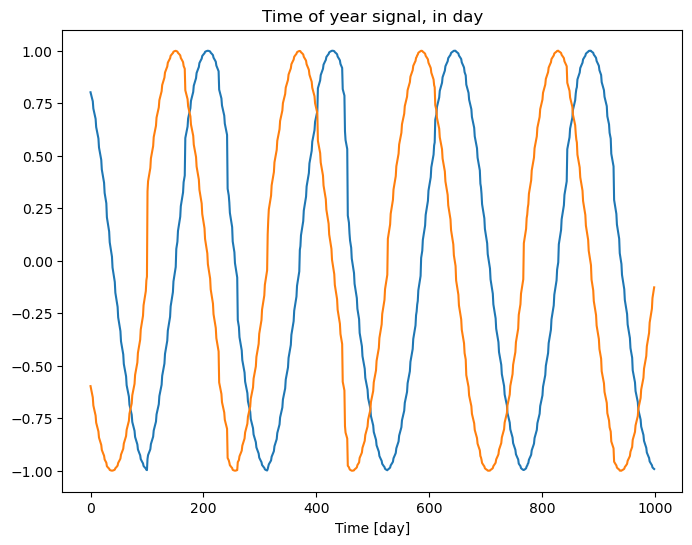

In [21]:
if debug_mode:
    plt.plot(np.array(stock_list[0]['Year sin'])[:1000])
    plt.plot(np.array(stock_list[0]['Year cos'])[:1000])
    plt.xlabel('Time [day]')
    plt.title('Time of year signal, in day')

In [22]:
if debug_mode:
    stock_list[5].head()

In [23]:
#df processing
for stock in stock_list:
    stock.name = stock.iloc[0,0]
    stock.pop("ts_code") #pop the stock code
    #stock.pop("pre_close") #pop previous day close price

In [24]:
if debug_mode:
    stock_list[0].head()

# MA implementation

In [25]:
ma_label = 'open'

In [26]:
for stock in stock_list:
    
    #MA

    processing_row = stock[ma_label].to_frame()

    stock['sma5'] = processing_row[ma_label].rolling(5).mean()

    stock['ema5'] = processing_row[ma_label].ewm(span=5).mean()

    stock['ema20'] = processing_row[ma_label].ewm(span=20).mean()

    stock['ema50'] = processing_row[ma_label].ewm(span=50).mean()

    

    # # Golden Cross  implementation
    # np.where(stock['ema20'] > stock['ema50'], 1, 0)

    # stock['ema20_50_GC'] = 0 

    # for i in range(stock.shape[0]):
    #     if i == 0:
    #         pass
    #     elif stock['ema20'][i] >= stock['ema50'][i] and stock['ema20'][i-1] < stock['ema50'][i-1]: #slow code, works for now
    #         stock['ema20_50_GC'][i] = 1



    stock.dropna(inplace=True)
    

In [27]:
# #GC value count inspction
# for stock in stock_list:
#     print(stock['ema20_50_GC'].value_counts())



In [28]:
display(stock_list[0])

,open,high,low,close,pre_close,pct_chg,vol,amount,index_open,index_high,index_low,index_close,index_pre_close,index_pct_chg,Year sin,Year cos,sma5,ema5,ema20,ema50
4,6.19,6.24,5.90,6.02,6.19,-2.7500,111481.38,6.729219e+04,887.5430,883.5050,898.5050,875.5760,885.8200,0.1945,0.759152,-0.650913,6.194,6.194455,6.194201,6.194081
5,6.02,6.02,5.76,5.90,6.02,-1.9900,54461.62,3.200359e+04,875.2710,885.3890,885.3890,869.3340,887.5430,-1.3827,0.724564,-0.689208,6.152,6.130707,6.157452,6.162090
6,5.90,6.15,5.81,6.06,5.90,2.7100,60944.28,3.681580e+04,881.4620,873.0770,888.2810,868.2120,875.2710,0.7073,0.712601,-0.701570,6.114,6.049024,6.108775,6.120009
7,6.06,6.20,6.04,6.14,6.06,1.3200,52046.44,3.184328e+04,883.1960,881.1410,890.4030,871.8210,881.4620,0.1967,0.700427,-0.713724,6.070,6.052831,6.100344,6.111417
8,6.14,6.27,6.01,6.20,6.14,0.9800,72994.06,4.505419e+04,884.1710,882.8420,888.0160,871.2890,883.1960,0.1104,0.688046,-0.725667,6.062,6.082663,6.106705,6.115124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4135,13.40,13.75,13.35,13.70,13.36,2.5449,1615831.92,2.197502e+06,3998.2442,3961.9919,4003.3178,3944.4396,3959.1798,0.9867,-0.383078,0.923716,13.262,13.228249,12.484849,12.083849
4136,13.58,13.58,13.06,13.11,13.70,-4.3066,1392584.28,1.848278e+06,3953.4433,3976.1722,3983.4332,3950.3203,3998.2442,-1.1205,-0.334918,0.942247,13.360,13.345499,12.589149,12.142521
4137,13.15,13.36,13.14,13.24,13.11,0.9916,902285.13,1.194285e+06,3945.6813,3953.5482,3964.3957,3939.9795,3953.4433,-0.1963,-0.318660,0.947869,13.322,13.280333,12.642563,12.182030
4138,13.23,13.40,13.08,13.23,13.24,-0.0755,974061.10,1.287868e+06,3954.8857,3952.7885,3972.7381,3935.7668,3945.6813,0.2333,-0.302308,0.953210,13.302,13.263555,12.698510,12.223127


# Final data check

In [29]:
display(stock_list[0])
display(stock_list[50])

,open,high,low,close,pre_close,pct_chg,vol,amount,index_open,index_high,index_low,index_close,index_pre_close,index_pct_chg,Year sin,Year cos,sma5,ema5,ema20,ema50
4,6.19,6.24,5.90,6.02,6.19,-2.7500,111481.38,6.729219e+04,887.5430,883.5050,898.5050,875.5760,885.8200,0.1945,0.759152,-0.650913,6.194,6.194455,6.194201,6.194081
5,6.02,6.02,5.76,5.90,6.02,-1.9900,54461.62,3.200359e+04,875.2710,885.3890,885.3890,869.3340,887.5430,-1.3827,0.724564,-0.689208,6.152,6.130707,6.157452,6.162090
6,5.90,6.15,5.81,6.06,5.90,2.7100,60944.28,3.681580e+04,881.4620,873.0770,888.2810,868.2120,875.2710,0.7073,0.712601,-0.701570,6.114,6.049024,6.108775,6.120009
7,6.06,6.20,6.04,6.14,6.06,1.3200,52046.44,3.184328e+04,883.1960,881.1410,890.4030,871.8210,881.4620,0.1967,0.700427,-0.713724,6.070,6.052831,6.100344,6.111417
8,6.14,6.27,6.01,6.20,6.14,0.9800,72994.06,4.505419e+04,884.1710,882.8420,888.0160,871.2890,883.1960,0.1104,0.688046,-0.725667,6.062,6.082663,6.106705,6.115124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4135,13.40,13.75,13.35,13.70,13.36,2.5449,1615831.92,2.197502e+06,3998.2442,3961.9919,4003.3178,3944.4396,3959.1798,0.9867,-0.383078,0.923716,13.262,13.228249,12.484849,12.083849
4136,13.58,13.58,13.06,13.11,13.70,-4.3066,1392584.28,1.848278e+06,3953.4433,3976.1722,3983.4332,3950.3203,3998.2442,-1.1205,-0.334918,0.942247,13.360,13.345499,12.589149,12.142521
4137,13.15,13.36,13.14,13.24,13.11,0.9916,902285.13,1.194285e+06,3945.6813,3953.5482,3964.3957,3939.9795,3953.4433,-0.1963,-0.318660,0.947869,13.322,13.280333,12.642563,12.182030
4138,13.23,13.40,13.08,13.23,13.24,-0.0755,974061.10,1.287868e+06,3954.8857,3952.7885,3972.7381,3935.7668,3945.6813,0.2333,-0.302308,0.953210,13.302,13.263555,12.698510,12.223127


,open,high,low,close,pre_close,pct_chg,vol,amount,index_open,index_high,index_low,index_close,index_pre_close,index_pct_chg,Year sin,Year cos,sma5,ema5,ema20,ema50
4,3.43,3.48,3.37,3.44,3.42,0.5800,1841.65,630.2068,887.5430,883.5050,898.5050,875.5760,885.8200,0.1945,0.759152,-0.650913,3.360,3.382038,3.365206,3.362035
5,3.45,3.46,3.36,3.43,3.44,-0.2900,1610.50,547.8560,875.2710,885.3890,885.3890,869.3340,887.5430,-1.3827,0.724564,-0.689208,3.378,3.406872,3.383093,3.378200
6,3.42,3.49,3.40,3.48,3.43,1.4600,2258.03,777.9526,881.4620,873.0770,888.2810,868.2120,875.2710,0.7073,0.712601,-0.701570,3.406,3.411520,3.390071,3.384912
7,3.47,3.49,3.41,3.48,3.48,0.0000,2772.47,954.1027,883.1960,881.1410,890.4030,871.8210,881.4620,0.1967,0.700427,-0.713724,3.432,3.431805,3.403888,3.397095
8,3.47,3.56,3.42,3.53,3.48,1.4400,4025.47,1407.4897,884.1710,882.8420,888.0160,871.2890,883.1960,0.1104,0.688046,-0.725667,3.448,3.444877,3.414492,3.406551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3920,13.72,13.79,13.57,13.79,13.69,0.7305,49745.92,68044.9130,3998.2442,3961.9919,4003.3178,3944.4396,3959.1798,0.9867,-0.383078,0.923716,13.762,13.737769,13.622803,13.602945
3921,13.79,13.81,13.50,13.55,13.79,-1.7404,47332.20,64308.5080,3953.4433,3976.1722,3983.4332,3950.3203,3998.2442,-1.1205,-0.334918,0.942247,13.770,13.755179,13.638727,13.610281
3922,13.53,13.64,13.49,13.60,13.55,0.3690,26568.19,36080.4420,3945.6813,3953.5482,3964.3957,3939.9795,3953.4433,-0.1963,-0.318660,0.947869,13.714,13.680119,13.628372,13.607132
3923,13.60,13.66,13.48,13.60,13.60,0.0000,26729.47,36301.8130,3954.8857,3952.7885,3972.7381,3935.7668,3945.6813,0.2333,-0.302308,0.953210,13.674,13.653413,13.625670,13.606853


# Models Area

In [30]:
# stacked_lstm_1 = Sequential(

#     [

#         LSTM(units = 32, activation='tanh', return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001) ),
#         LSTM(units = 32, activation='tanh', return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2(0.001) ),
#         Dense(units = 16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001) ),
#         Dense(units = 1, activation = 'linear') #output 

#     ],

#     name = "simple_stacked_lstm_stock_1"

# )

In [31]:
# stacked_lstm_1_plus = Sequential(

#     [

#         LSTM(units = 64, activation='tanh', return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001) ),
#         LSTM(units = 64, activation='tanh', return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2(0.001) ),
#         Dense(units = 24, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001) ),
#         Dense(units = 8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001) ),
#         Dense(units = 1, activation = 'linear') #output 

#     ],

#     name = "simple_stacked_lstm_stock_1_plus"

# )

# Training for all models

In [32]:
#data storage
evaluation_result = {}


#meta data
labels = ['open']

eval_iteration = 2 #the number of evaluation iterations for individual stock

In [33]:
#main training loop
stock_training_range = 10 #len(stock_list)

learning_rate = 0.001

for stock_index in range(129, 300):


    #set up

    current_stock = stock_list[stock_index] #df

    column_indices = {name: i for i, name in enumerate(current_stock.columns)}

    n = len(current_stock)
    num_features = current_stock.shape[1]
    num_row = current_stock.shape[0]

    #split training, cross val and testing data
    #note since this is a time series data, the split is fixed. No randomization
    #no testing data, only cross val data

    train_data_p = 0.7  #percentage of train data
    val_data_p = 0.2

    train_df = current_stock[ 0 : int(n * train_data_p) ]
    val_df = current_stock[int( n * train_data_p) : int(n * (train_data_p + val_data_p)) ]
    test_df = current_stock[int( n * (train_data_p + val_data_p)) : ]



    #debug area
    ########################################################################
    if debug_mode and stock_index < debug_output_n :
        print("df instances : ", num_row)
        print("df features : ", num_features)
        display(current_stock)


    if debug_mode and stock_index < debug_output_n : 
        print("train_df instances : ", len(train_df))
        display(train_df)
        
        for x in range(4): 
            print()
            
        print("val_df instances : ", len(val_df))
        display(val_df)
        
        for x in range(4): 
            print()
            
        print("test_df instances : ", len(test_df))
        display(test_df)
    ########################################################################


    #normalize data
    train_mean = train_df.mean()
    train_std = train_df.std()

    #compute the z score to normalize data between features
    train_df = (train_df - train_mean)/train_std
    val_df = (val_df - train_mean)/train_std
    test_df = (test_df - train_mean)/train_std





    #visuliazation
    ########################################################################
    if debug_mode and stock_index < debug_output_n :
        df_std = (current_stock - train_mean) / train_std
        df_std = df_std.melt(var_name='Column', value_name='Normalized')
        plt.figure(figsize=(12, 6))
        ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
        _ = ax.set_xticklabels(current_stock.keys(), rotation=90)
    ########################################################################



    #window setup area single step
    ##############################################################################################

    #set up the 7 timesteps window
    win_7 = time_window_generator(input_width = 6, label_width = 1, shift = 1, train_df=train_df, val_df=val_df, test_df=test_df, label_columns = labels)
    #set up the batch size
    win_7.batch_size = 8

    if debug_mode and stock_index < debug_output_n :
        print(win_7)
        aux_functions.window_inspection(win_7, debug_mode, labels)
    


    #set up 30 timesteps window
    win_30 = time_window_generator(input_width = 29, label_width = 1, shift = 1, train_df=train_df, val_df=val_df, test_df=test_df, label_columns = labels)
    #set up the batch size
    win_30.batch_size = 8

    if debug_mode and stock_index < debug_output_n :
        print(win_30)
        aux_functions.window_inspection(win_30, debug_mode, labels)

    ##############################################################################################


    # multi step windows
    ##############################################################################################

    win_29_7 = time_window_generator(input_width= 29, label_width= 7, shift = 7, train_df=train_df, val_df= val_df, test_df=test_df, label_columns=labels)
    win_29_7.batch_size = 8


    if debug_mode and stock_index < debug_output_n :
        print(win_29_7)
        aux_functions.window_inspection(win_29_7, debug_mode, labels)


    ###############################################################################################






    #individual stock model performance evaluate 
    result = []



    #train models for n numbers of iteration to check the performance
    for iter in range(eval_iteration):

        #clear backend, prevent memory overflow
        tf.keras.backend.clear_session()

        #tensorboard logging doesnt work for now
        # logpath_exact = tf_log_dir + str(stock_list[stock_index].name) + datetime.now().strftime("%Y%m%d-%H%M%S")
        # tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logpath_exact)


        #chose window
        train_target = win_29_7



        #temp model area
        ##############################################################################################

        # single step
        stacked_lstm_1 = Sequential(

            [

                LSTM(units = 32, activation='tanh', return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001) ),
                LSTM(units = 32, activation='tanh', return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2(0.001) ),
                Dense(units = 16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001) ),
                Dense(units = len(labels), activation = 'linear') #output 

            ],

            name = "simple_stacked_lstm_stock_1"

        )



        stacked_lstm_2_multilr = Sequential(

            [

                LSTM(units = 64, activation='tanh', return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001) ),
                LSTM(units = 64, activation='tanh', return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2(0.001) ),
                Dense(units = 24, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001) ),
                Dense(units = 8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001) ),
                Dense(units = len(labels), activation = 'linear') #output 

            ],

            name = "simple_stacked_lstm_2_multilr"

        )



        # stacked_lstm_test = Sequential(

        #     [

        #         LSTM(units = 32, activation='tanh', return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001) ),
        #         LSTM(units = 32, activation='tanh', return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2(0.001) ),
        #         Dense(units = 20, activation = 'linear', kernel_initializer=tf.initializers.zeros()) #output 

        #     ],

        #     name = "simple_stacked_lstm_stock_1"

        # )




        # multi step


        stacked_lstm_3_multilr_multistep = Sequential(

            [

                LSTM(units = 64, activation='tanh', return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001) ),
                LSTM(units = 64, activation='tanh', return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2(0.001) ),
                Dense(units = train_target.label_width * len(labels), activation = 'linear', kernel_initializer=tf.initializers.zeros()), #output
                tf.keras.layers.Reshape([train_target.label_width, len(labels)]) 

            ],

            name = "simple_stacked_lstm_stock_1_multistep"

        )



        ##############################################################################################



        #chose model to run and evaluate
        train_model = stacked_lstm_3_multilr_multistep



        #compile and fit
        data_model = aux_functions.compile_and_fit(train_model, train_target, epochs=60, es_patience=4, es_monitor='val_loss', es_mode='min', lr=learning_rate)


        result.append([train_model.evaluate(train_target.val), train_model.evaluate(train_target.test)])
    




    average_mape_val = 0
    average_mape_test = 0
    
    for result_i in range(len(result)):
        average_mape_val += result[result_i][0][1]
        average_mape_test += result[result_i][1][1]
    
    average_mape_val = average_mape_val/len(result)
    average_mape_test = average_mape_test/len(result)



    evaluation_result[stock_list[stock_index].name] = [average_mape_val, average_mape_test, result]



    #data logging

    if performance_log == True:

        performance_log_csv = open(data_log_csv_path, 'a', encoding='UTF8', newline='')
        csv_writer = csv.writer(performance_log_csv)
        csv_writer.writerow([stock_list[stock_index].name, average_mape_val, average_mape_test, eval_iteration, len(train_df), len(val_df), len(test_df), train_model.name])
        performance_log_csv.close()


    #garbage collection test 1
    del train_model



Epoch 1/60
264/264 [==============================] - 6s 10ms/step - loss: 0.2031 - mean_absolute_percentage_error: 165.3845 - val_loss: 1.6745 - val_mean_absolute_percentage_error: 55.6445 - lr: 0.0010
Epoch 2/60
264/264 [==============================] - 2s 8ms/step - loss: 0.0601 - mean_absolute_percentage_error: 111.9281 - val_loss: 1.3626 - val_mean_absolute_percentage_error: 62.7790 - lr: 0.0010
Epoch 3/60
264/264 [==============================] - 2s 8ms/step - loss: 0.0457 - mean_absolute_percentage_error: 100.2038 - val_loss: 1.2866 - val_mean_absolute_percentage_error: 57.8372 - lr: 0.0010
Epoch 4/60
264/264 [==============================] - 2s 8ms/step - loss: 0.0395 - mean_absolute_percentage_error: 105.5184 - val_loss: 1.1407 - val_mean_absolute_percentage_error: 62.7759 - lr: 0.0010
Epoch 5/60
264/264 [==============================] - 2s 8ms/step - loss: 0.0409 - mean_absolute_percentage_error: 108.7348 - val_loss: 1.3313 - val_mean_absolute_percentage_error: 56.9755 - 

In [34]:
#check all output of the dictionaries db

for key, value in evaluation_result.items():
    print("Stock Model for : ", key)
    print("Average MAPE of val data_set : ", value[0])
    print("Average MAPE of test data_set : ", value[1])
    print()

Stock Model for :  002352.SZ
Average MAPE of val data_set :  82.4873046875
Average MAPE of test data_set :  13.111923694610596

Stock Model for :  002353.SZ
Average MAPE of val data_set :  63.567100524902344
Average MAPE of test data_set :  81.6961441040039

Stock Model for :  002371.SZ
Average MAPE of val data_set :  37.86088943481445
Average MAPE of test data_set :  69.10385513305664

Stock Model for :  002375.SZ
Average MAPE of val data_set :  6.710326910018921
Average MAPE of test data_set :  3.7457454204559326

Stock Model for :  002384.SZ
Average MAPE of val data_set :  179.4168701171875
Average MAPE of test data_set :  194.1241455078125

Stock Model for :  002385.SZ
Average MAPE of val data_set :  18.06636667251587
Average MAPE of test data_set :  16.48928475379944

Stock Model for :  002399.SZ
Average MAPE of val data_set :  15.547503471374512
Average MAPE of test data_set :  13.041521549224854

Stock Model for :  002410.SZ
Average MAPE of val data_set :  25.941500663757324
Ave

In [35]:

# header = ["stock_code","Average MAPE of val data_set", "Average MAPE of test data_set", "Iteration_number"]   

# with open("training_log/simple_models.csv", 'w', encoding='UTF8', newline='') as file:

#     writer = csv.writer(file)

#     writer.writerow(header)

#     for key, value in evaluation_result.items():
#         writer.writerow([key, value[0], value[1]])